**Datasets can be downloaded [here](https://www.dropbox.com/sh/05w05r1nwv4cira/AAB2HaPCQgUM8ZgxICyg7wlEa?dl=0)**  
Ref: Nestorowa, S. et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood 128, e20-31 (2016).

From `STREAM V4.0`, some changes of default function setting have been made to enable STREAM analysis to be faster and more scalable. This tutorial is only used to reproduce the results in STREAM paper.

In [1]:
%matplotlib inline

In [2]:
import stream as st

In [3]:
st.__version__

'0.4.2'

### Read in data

In [4]:
adata=st.read(file_name='./data/data_Nestorowa.tsv.gz',workdir='./stream_result')

Saving results in: ./stream_result


> To load and use 10x Genomics single cell RNA-seq data processed with Cell Ranger:  
(Make sure **'genes.tsv'** and **'barcodes.tsv'** are under the same folder as **'matrix.mtx'**)  
```python
adata=st.read(file_name='./filtered_gene_bc_matrices/hg19/matrix.mtx',file_format='mtx')
```

> If the Anndata object is already created, to run STREAM, simply specify the experiment type and work directory:
```python
adata.uns['experiment'] = 'rna-seq'
st.set_workdir(adata,'./result_stream')
```

#### read in cell labels and label color

In [5]:
st.add_metadata(adata,file_name='./data/metadata.tsv')

> **Note**: if cell label file or cell color file is not provided, users need to run:  
`st.add_cell_labels(adata) #'unknown' will be added as the default label for all cells` 
`st.add_cell_colors(adata) #'random color will be generated for each cell label  `

#### Other useful preprocessing steps when dealing with raw-count data

Normalize gene expression based on library size  
`st.normalize_per_cell(adata)`

Logarithmize gene expression  
`st.log_transform(adata)` 

Remove mitochondrial genes  
`st.remove_mt_genes(adata)`

Filter out cells  
`st.filter_cells(adata)` 

Filter out genes

In [6]:
st.filter_genes(adata,min_num_cells = 5)

Filter genes based on min_num_cells
After filtering out low-expressed genes: 
1656 cells, 4762 genes


**check parameters**  
`st.select_variable_genes?`

Please check if the blue curve fits the points well.  
If not, please adjust the parameter **'loess_frac'** (By default, `loess_frac=0.01`) until the blue curve fits well.   

239 variable genes are selected


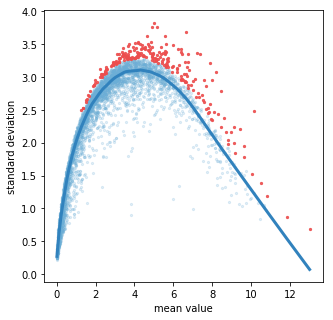

In [7]:
st.select_variable_genes(adata,loess_frac=0.1)

**Note: Alternatively, user can also select top  principal components using all genes or variable genes:**
- use all genes   
`st.select_top_principal_components(adata,n_pc=15,first_pc=True)`
- use variable genes   
    - users need to first run `st.select_variable_genes(adata,loess_frac=0.01, n_genes=2000)`  
    - `st.select_top_principal_components(adata,feature='var_genes',n_pc=15,first_pc=True)`

**check parameters**  
`st.dimension_reduction?`

Tips:

>by default `n_components =3`  
For biological process with simple bifurcation or linear trajectory, two components would be recommended  
e.g, `st.dimension_reduction(adata,n_components =2)`

>Several alternative dimension reduction methods are also supported, `mlle`(modified locally linear embedding),`se`(spectral embedding), `umap`, `pca`. From `STREAM v4.0`, by default, `method ='se'`.  
- For **large dataset**, `se`(Spectral Embedding) works faster than MLLE while preserving the similar compact structure to **MLLE**.  
e.g. `st.dimension_reduction(adata,method ='se')`

From `STREAM v4.0`, the parameter `nb_pct` (the percentage of neighbor cells) will be deprecated. Instead, please use `n_neighbors` (the number of neighbor cells). 

In [8]:
st.dimension_reduction(adata,method='mlle',nb_pct=0.1,n_components=3,n_jobs=4)

feature var_genes is being used ...
4 cpus are being used ...


> Alternatively, using top principal components as features:
`st.dimension_reduction(adata,method='se',feature='top_pcs',n_neighbors=30, n_components=3)`

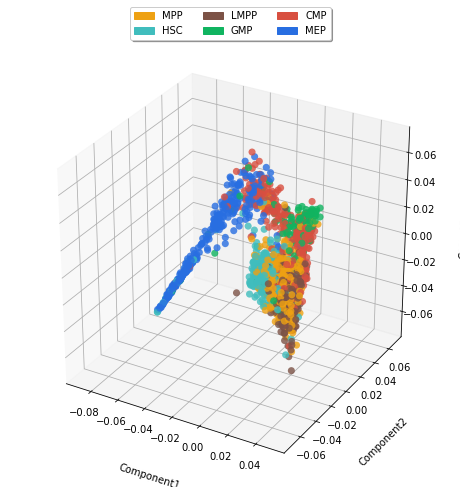

In [9]:
st.plot_dimension_reduction(adata)

**check parameters**  
`st.plot_visualization_2D?`

Tips:  
> Before the downstream **elastic principal graph learning**, it is important to visualize the top components in 2D plane with **UMAP** (by default) or **tSNE**(`st.plot_visualization_2D(adata,method='tsne')`) to confirm the existence of meaningful biological trajectory pattern 

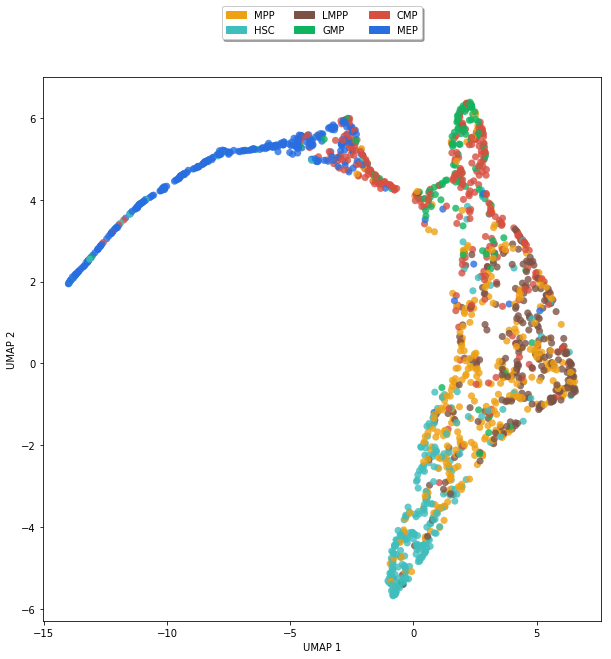

In [10]:
st.plot_visualization_2D(adata,nb_pct=0.1)

**check parameters**  
`st.seed_elastic_principal_graph?`

Tips:
>To better scale up STREAM to large datasets, since **version 0.3.8**, the default **clustering method** has been changed from **'ap'** (affinity propagation) to **'kmeans'**. Users can specify `clustering = 'ap'` to reproduce the analyses in STREAM paper:  
i.e. `st.seed_elastic_principal_graph(adata,clustering='ap')`

>If cells form a big bulk in MLLE space, **'ap'** may generate too many branches.   
In that case, try `clustering = 'kmeans'` or `clustering = 'sc'` to avoid a too complex initial strcuture

>For noisy dataset, **spectral clustering** is proved to work better to get rid of noisy branches  
e.g. `st.seed_elastic_principal_graph(adata,clustering='sc',n_clusters=10)`

In [11]:
st.seed_elastic_principal_graph(adata,n_clusters=10)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3


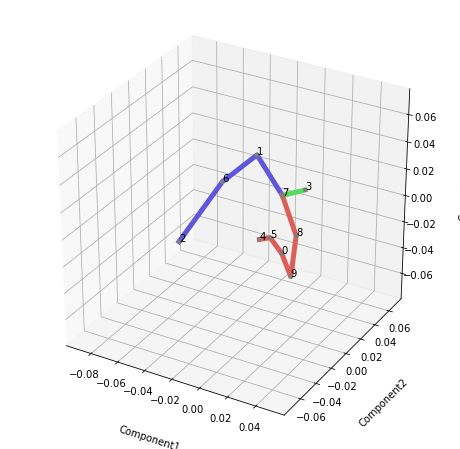

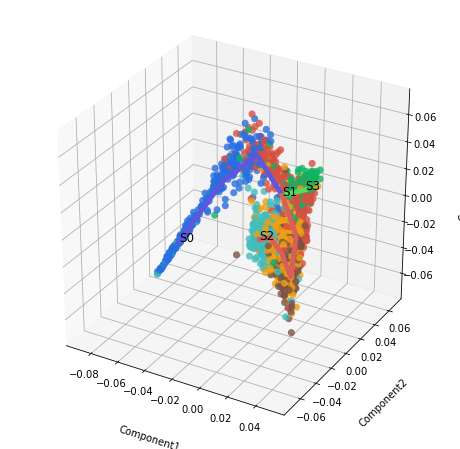

In [12]:
st.plot_branches(adata)
st.plot_branches_with_cells(adata,fig_legend=False)

**check parameters**  
`st.elastic_principal_graph?`

> `epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

Tips:  

- Add **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [13]:
st.elastic_principal_graph(adata,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.02)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 1656 points and 3 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50
	
0.0001097
	
50
	
49
	
44
	
2
	
0
	
0
	
6.533e-05
	
6.253e-05
	
0.964
	
0.9655
	
3.93e-05
	
5.071e-06
	
0.0002536
	
0.01268
	
0


9.626 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 5


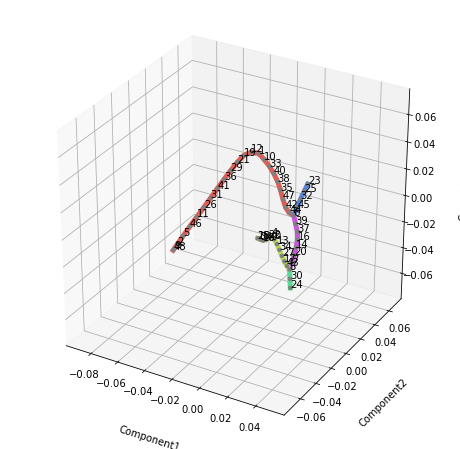

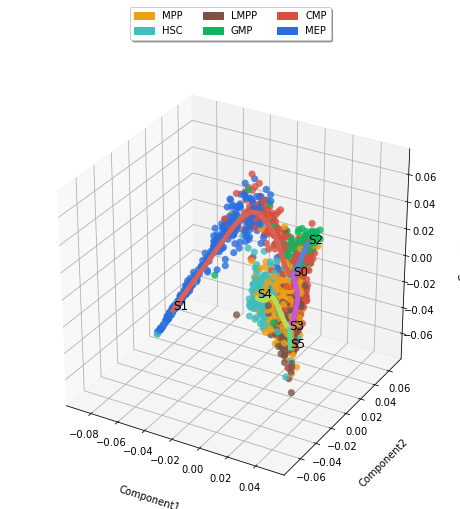

In [14]:
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

Tips:  
- Add **'epg_trimmingradius'** will help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.optimize_branching(adata,epg_trimmingradius=0.1)`  

Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 80 nodes on 1656 points and 3 dimensions"


[1]
 "Using a single core"


Nodes = 
50
 
51
 
52
 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||80
	
0.0001768
	
80
	
79
	
74
	
2
	
0
	
0
	
8.208e-05
	
8.136e-05
	
0.9547
	
0.9551
	
9.214e-05
	
2.617e-06
	
0.0002094
	
0.01675
	
0


3.204 sec elapsed

Number of branches after optimizing branching: 5


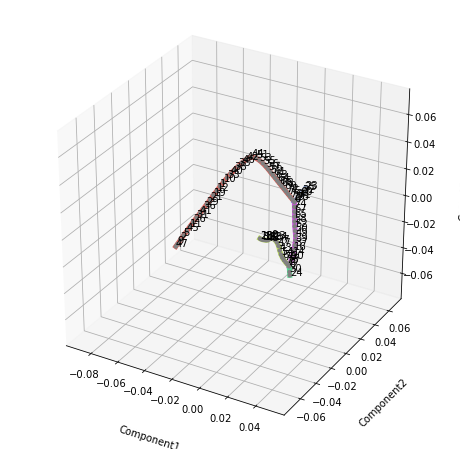

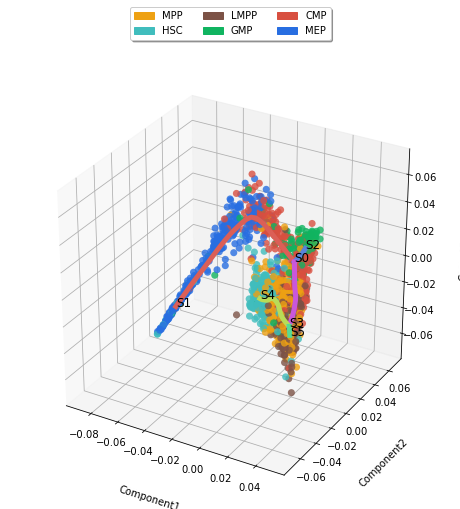

In [15]:
### optional step
st.optimize_branching(adata,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.1,reset=True)
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

Other optional steps:

- Prune branches:  
`st.prune_elastic_principal_graph?`  
`st.prune_elastic_principal_graph(adata)`


- Shift branching node:  
`st.shift_branching?`  
`st.shift_branching(adata)`

**check parameters**  
`st.extend_elastic_principal_graph?`  

Tips:  
- Add **'epg_trimmingradius'** will help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.extend_elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

Extending leaves with additional nodes ...
Number of branches after extending leaves: 5


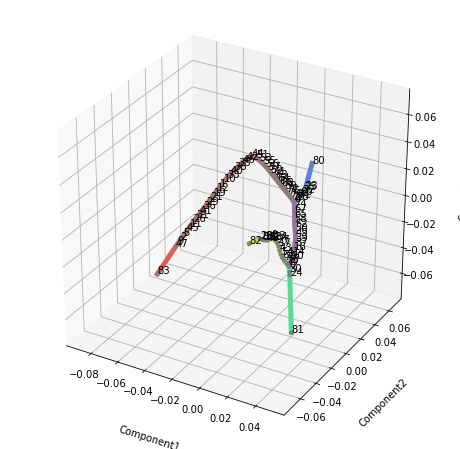

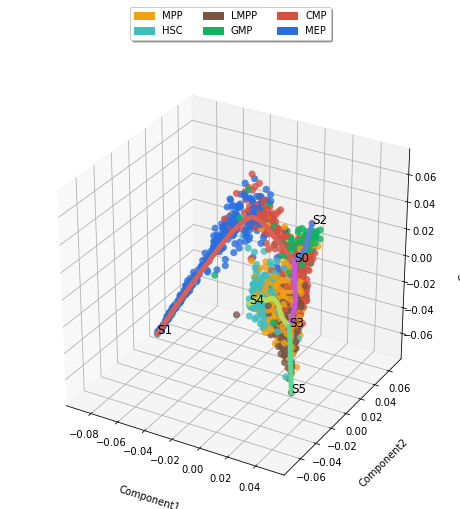

In [16]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata)
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

/Users/huidong/anaconda3/envs/env_STREAM/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


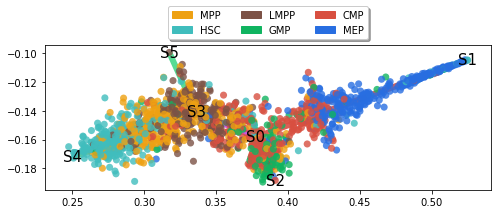

In [17]:
st.plot_flat_tree(adata)

Validate the learned structure by visualizing the branch assignment

Importing precomputed umap visualization ...
Importing precomputed umap visualization ...


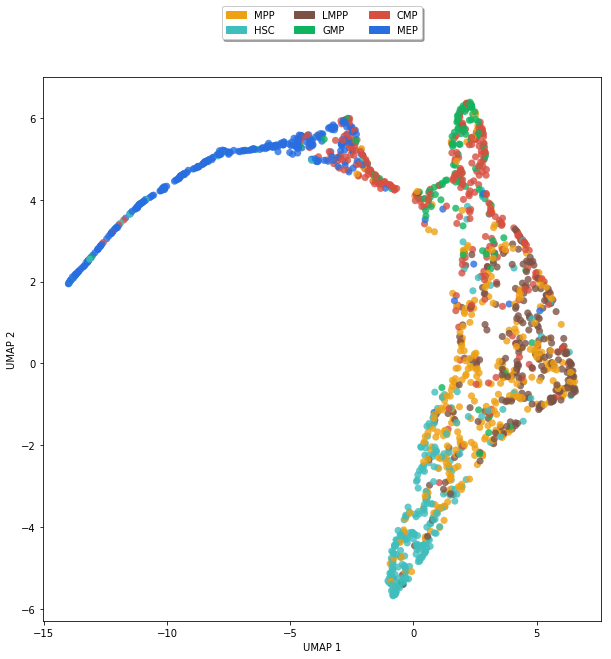

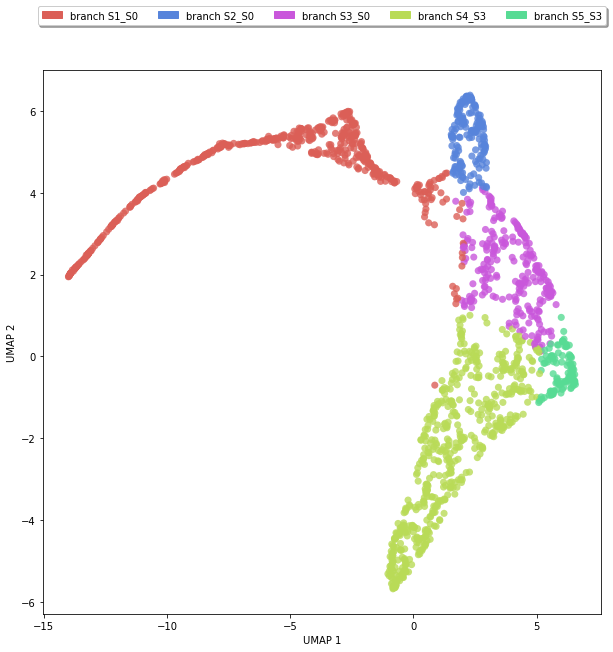

In [18]:
st.plot_visualization_2D(adata)
st.plot_visualization_2D(adata,color_by='branch',fig_legend_ncol=6)

**check parameters**  
`st.subwaymap_plot?`

By default **percentile_dist=95**, to make cells more conpact around the branches, try to **increase percentile_dist to beween 95 and 100**

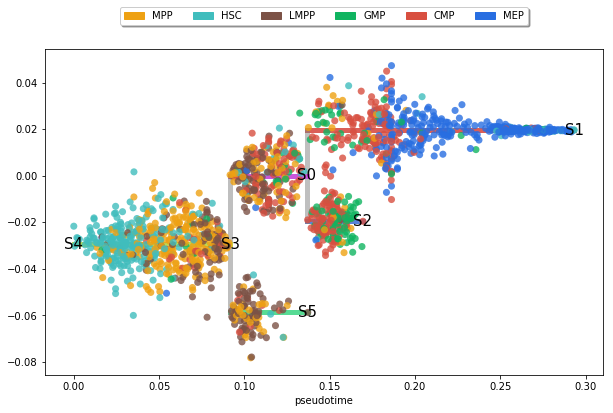

In [19]:
st.subwaymap_plot(adata,root='S4',fig_legend_ncol=6) 

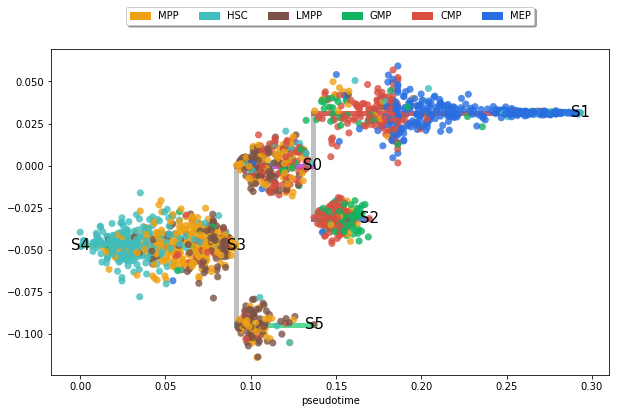

In [20]:
st.subwaymap_plot(adata,root='S4',fig_legend_ncol=6,percentile_dist=100) 

**check parameters**  
`st.stream_plot?`

By default **factor_min_win=2.0**, lowering it (between 1.0 and 2.0) can make smoother stream plot

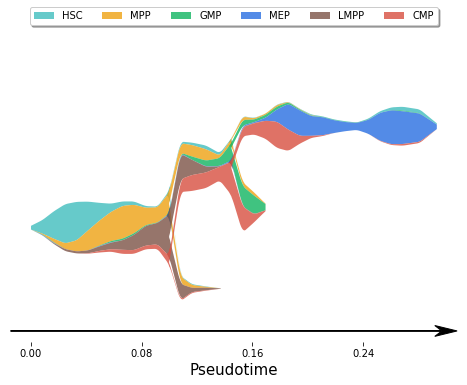

In [21]:
st.stream_plot(adata,root='S4',fig_legend_ncol=6,fig_size=(8,8),
               tick_fontsize=10,label_fontsize=15,factor_min_win=2.0)

#### Visualize genes

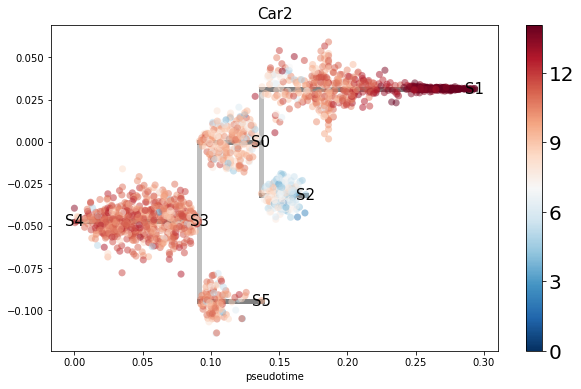

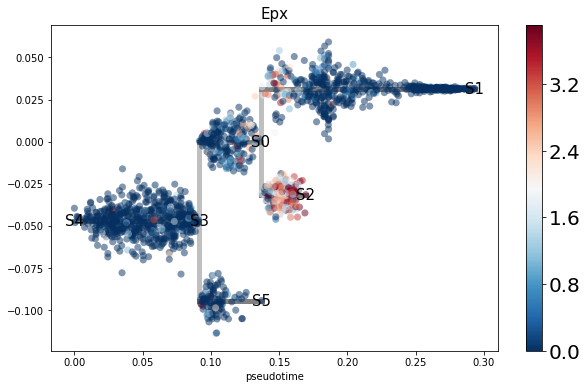

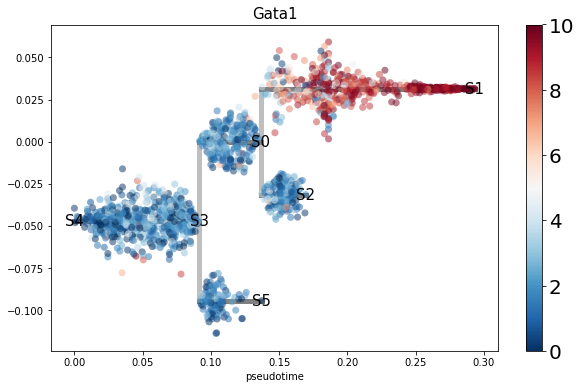

In [22]:
st.subwaymap_plot_gene(adata,percentile_dist=100,root='S4',genes=['Gata1','Car2','Epx']) 

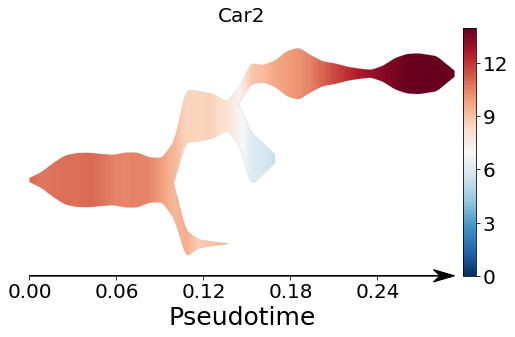

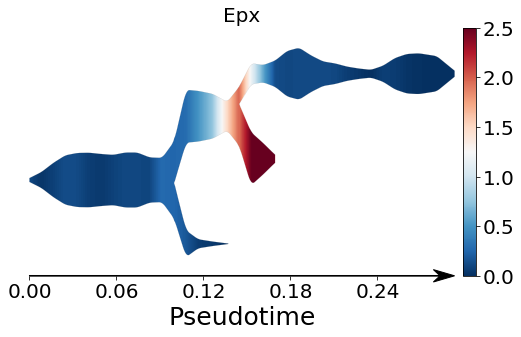

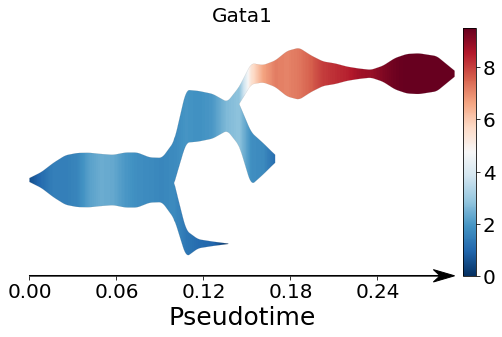

In [23]:
st.stream_plot_gene(adata,root='S4',fig_size=(8,8),genes=['Gata1','Car2','Epx'])

#### Detect marker genes for each leaf branch

**'preference'** is only used to adjust the order of comparions (in coordance with subway_map plot and stream plot), it will not affect the final detected genes

In [24]:
st.detect_leaf_genes(adata,root='S4',preference=['S2','S1'],n_jobs=4)

Filtering out genes that are expressed in less than 5 cells ...
4 cpus are being used ...
4767 genes are being scanned ...


In [25]:
adata.uns['leaf_genes_all'].head()

,zscore,H_statistic,H_pvalue,S4S3_pvalue,S0S2_pvalue,S0S1_pvalue,S3S5_pvalue
Mfsd2b,1.727966,881.626737,8.555800e-191,1.657480e-266,1.126552e-147,1.000000e+00,1.011551e-134
Gata1,1.726258,850.525598,4.764381e-184,2.689668e-245,2.014387e-139,1.000000e+00,6.145559e-133
Vamp5,1.569116,780.479557,7.407878e-169,9.072414e-169,5.907843e-166,1.000000e+00,1.801894e-125
Mpl,1.659358,769.363600,1.907156e-166,1.000000e+00,4.054496e-151,2.763994e-206,1.378171e-51
Klf1,1.726603,746.405509,1.815981e-161,1.282394e-199,2.956462e-108,1.000000e+00,1.398862e-100


In [26]:
adata.uns['leaf_genes'].keys()

dict_keys([('S4', 'S3'), ('S0', 'S2'), ('S0', 'S1'), ('S3', 'S5')])

leaf branch S0_S1 genes

In [27]:
adata.uns['leaf_genes'][('S0','S1')]

,zscore,H_statistic,H_pvalue,S4S3_pvalue,S0S2_pvalue,S0S1_pvalue,S3S5_pvalue
Mfsd2b,1.727966,881.626737,8.555800e-191,1.657480e-266,1.126552e-147,1.0,1.011551e-134
Gata1,1.726258,850.525598,4.764381e-184,2.689668e-245,2.014387e-139,1.0,6.145559e-133
Vamp5,1.569116,780.479557,7.407878e-169,9.072414e-169,5.907843e-166,1.0,1.801894e-125
Klf1,1.726603,746.405509,1.815981e-161,1.282394e-199,2.956462e-108,1.0,1.398862e-100
Emb,-1.561301,739.903106,4.668693e-160,1.807689e-114,7.923853e-169,1.0,1.826645e-126
...,...,...,...,...,...,...,...
Ifi211,-1.593496,21.840236,7.041938e-05,2.952514e-04,8.195160e-03,1.0,8.122207e-03
Mfsd8,1.628899,20.973341,1.066268e-04,1.487719e-03,1.487719e-03,1.0,9.588634e-03
Xab2,1.563574,18.207974,3.984737e-04,8.252178e-03,6.300138e-03,1.0,7.657346e-03
Pde5a,1.687475,17.915379,4.578832e-04,5.679907e-03,5.679907e-03,1.0,7.271928e-03


In [28]:
adata.obs.head()

,label,label_color,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S2_pseudotime,S5_pseudotime,S4_pseudotime,S1_pseudotime
HSPC_025,MPP,#eea113,70,"(82, 8)","(S4, S3)",0.080712,0.002476,0.055724,0.010848,0.088776,0.056435,0.080712,0.212541
HSPC_031,MPP,#eea113,70,"(82, 8)","(S4, S3)",0.081038,0.003644,0.055398,0.010523,0.088451,0.056109,0.081038,0.212215
HSPC_037,MPP,#eea113,24,"(81, 8)","(S5, S3)",0.039849,0.000468,0.050612,0.005737,0.083664,0.039849,0.097297,0.207429
LT-HSC_001,HSC,#40bdbd,18,"(82, 8)","(S4, S3)",0.033336,0.011522,0.103100,0.058225,0.136153,0.103811,0.033336,0.259917
HSPC_001,MPP,#eea113,22,"(82, 8)","(S4, S3)",0.042385,0.008421,0.094051,0.049175,0.127103,0.094761,0.042385,0.250868


#### Save results

save `adata` to `.pkl` file (by default, it's named `stream_result.pkl`)

In [29]:
st.write(adata,file_name='stream_nestorowa16',file_format='pkl')

> saved `.pkl` file can be downloaded [here](https://www.dropbox.com/s/yj4grx0an5p8m76/stream_nestorowa16.pkl?dl=0)